### Mitochondria Pipeline

This notebook executes the Mitochondria Pipeline by 

1. consuming the mitochondria messages that have been sent to the "mitochondria_detection" topic
2. extracting the mitochondria time series tiff images and its meta data,
4. transforming the images by  breaking the 1536, 2048 pixelimage into patches of 256x256 images
5. submitting the smaller images to the wallaroo pipeline for inferencing
6. writing the predicted_masks to a file name on disk for later interpretation

In [14]:
# Step 1: Install the required packages (if you haven't already)

# import sys
 
# # setting path
# sys.path.append('..')
# sys.path.append('../../../..')

import os
from kafka import KafkaConsumer
import json
import IPython.display as display
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from lib.TiffImageUtils import TiffUtils
import tifffile as tiff

import pandas as pd

import wallaroo
from lib.CVDemoUtils import CVDemo
import numpy as np
from matplotlib import pyplot as plt
import cv2
from keras.utils import normalize
from lib.WallarooUtils import WallarooUtils

cvDemo = CVDemo()
w_utils = WallarooUtils()
tiff_utils = TiffUtils()


In [15]:
# build the patches

mitochondria_file = "https://storage.googleapis.com/wallaroo-public-data/csa_demo/computer-vision/examples/medical/bio-labs/atl-lab/images/ms-01-atl-3-22-23_9-50.tiff"
mitochondria_masks_file = "https://storage.googleapis.com/wallaroo-public-data/csa_demo/computer-vision/examples/medical/bio-labs/atl-lab/masks/ms-01-atl-3-22-23_9-50-masks.tiff"

patches_dict = tiff_utils.build_patches("patches", 
                                        (256,256), 
                                        256, 
                                        mitochondria_file, 
                                        mitochondria_masks_file )

created dir patches/ms-01-atl-3-22-23_9-50
saving file patches/ms-01-atl-3-22-23_9-50/ms-01-atl-3-22-23_9-50.tiff


### Securly connect this notebook to the Wallaroo Cluster


In [16]:
wl = wallaroo.Client()

wallarooPrefix = "product-uat-ee"
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}.api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}.keycloak.{wallarooSuffix}", 
                    auth_type="sso")

Please log into the following URL in a web browser:

	https://product-uat-ee.keycloak.wallaroocommunity.ninja/auth/realms/master/device?user_code=FXDD-AYRR

Login successful!


### Set the active Workspace

In [17]:
w_utils.set_workspace("bio-labs2", wl)

### Reserve resources needed from Wallaroo Cluster

In [18]:
deployment_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(1).memory("2Gi").build()


### Upload model to Wallaroo Cluster

In [19]:
model_name = 'mitochondria'
model = wl.upload_model(model_name, "models/mitochondria_epochs_15.onnx")

### Deploy Microscope Pipeline

In [20]:
pipeline_name = 'ms-01-atl-pp'
pipeline = wl.build_pipeline(pipeline_name) \
            .add_model_step(model) \
            .deploy(deployment_config = deployment_config)

### Test Deployed Pipeline

First we retrieve all the patch images from a recorded time series tiff recorded on one of our mircoscopes

In [21]:
sample_mitochondria_patches_path = "./patches/ms-01-atl-3-22-23_9-50"

patches = tiff_utils.get_all_patches(sample_mitochondria_patches_path)

Randomly we will retrive a 256x256 patch image and use it to do our semantic segmentation prediction.
This results in a predicted mask showing us where the mitochondria cells are located.

1. The first image is the input image
2. The 2nd image is the ground truth. The mask was created by a human who identified the mitochondria cells in the input image
3. The 3rd image is the predicted mask after running inference on the wallaroo pipeline

Play around with this a bit by re-exectuing this cell.  Each time it will randomly grab a path from the ms-01-atl-3-22-23_9-50.tiff time series tiff image

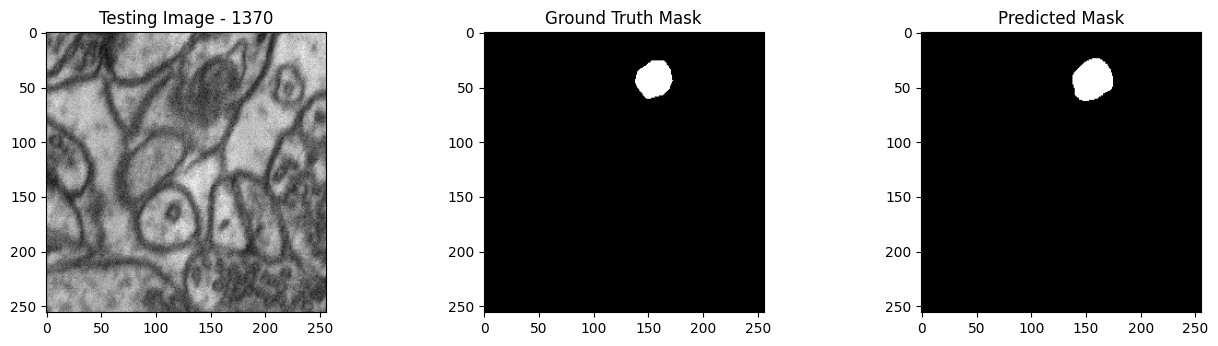

In [28]:
# get a sample 256x256 mitochondria image
random_patch = tiff_utils.get_random_patch_sample(patches)

# build the path to the image
patch_image_path = sample_mitochondria_patches_path + "/images/" + random_patch['patch_image_file']

# run inference in order to get the predicted 256x256 mask
predicted_mask = w_utils.run_semantic_segmentation_inference(pipeline, patch_image_path, 256,256, 0.2)

# # plot the results
test_image = random_patch['patch_image'][:,:,0]
test_image_title = f"Testing Image - {random_patch['index']}"

ground_truth_image = random_patch['patch_mask'][:,:,0]
ground_truth_image_title = "Ground Truth Mask"

predicted_mask_title = 'Predicted Mask'

tiff_utils.plot_test_results(test_image, test_image_title, \
                        ground_truth_image, ground_truth_image_title, \
                        predicted_mask, predicted_mask_title)


### Subsribe to the kafka mitochondria-detection topic


In [23]:

# # Define the Kafka consumer configuration
# consumer_config = {
#     'bootstrap_servers': '10.0.37.238:9092',  # Replace with your Kafka broker address
#     'client_id': 'mitochondria-pipeline',
#     'auto_offset_reset': 'earliest',  # Start reading from the earliest available message
#     'enable_auto_commit': True,  # Disable auto-commit of messages to control when to stop consuming
#     'value_deserializer': lambda x: x.decode('utf-8')
# }

# consumer = KafkaConsumer(**consumer_config)
# # Subscribe to the topic 
# TOPIC = 'mitochondria-detection-atl-3'
# consumer.subscribe([TOPIC])


### Consume images as they are posted to the "mitochondria_detection" topic 

Next we are going to 

1. Consume a mitochondria time series tiff image each time a microscope sends it to this topic
2. Break it down into 256x256 patch images
3. Have the pipeline run inference
4. Display the microscope image and the predicted mitochondia structures


In [24]:
# from PIL import Image
# SIZE=256


# num_messages_to_read = 60
# message_count = 0

# # process any msgs on the topic
# try:
#     for msg in consumer:
#         message_data = json.loads(msg.value)
 
#         # check if file exists
#         image_file_name = "../"+message_data['image_file_name']

#         if not os.path.exists(image_file_name):
#             continue

#         # Build patch images
#         patches = tiff_utils.build_patches("patches",(256,256), 256, image_file_name)

#         #
#         # iterate over the list of 256x256 images and run inference
#         #
#         for patch_file in patches['patches_img_list']:

#             # run inference in order to get the predicted 256x256 mask
#             predicted_mask = w_utils.run_semantic_segmentation_inference(pipeline, patch_file, 256,256, 0.2)

#             # plot the results
#             input_image = tiff_utils.read_image_resize(patch_file, SIZE, SIZE)          
#             input_image_title = f"{message_data['location']} - {os.path.basename(patch_file)}"

#             predicted_mask_title = 'Predicted Mask'

#             tiff_utils.plot_inferenced_results(input_image, input_image_title, \
#                                     predicted_mask, predicted_mask_title)
            
#             clear_output(wait=True) 
#             # allow user to view before moving on
#             time.sleep(1.5)

#         # Should we exit
#         message_count += 1  
#         if message_count >= num_messages_to_read:
#             consumer.close()
#             break

# except KeyboardInterrupt:
#     print("Interrupted by user. Exiting...")
#     tiff_utils.plot_inferenced_results(input_image, input_image_title, \
#                                     predicted_mask, predicted_mask_title)
#     consumer.close()
    


In [29]:
pipeline.undeploy()

name,ms-01-atl-pp
created,2023-05-24 17:01:27.166848+00:00
last_updated,2023-05-24 19:06:47.567368+00:00
deployed,False
tags,
versions,"3c79b38f-c180-4c0e-80fc-29d6ce7cbdc3, fb23d456-81ba-4ecd-ac5a-30c57bce06da, e307f718-5b00-4e6a-97ad-d03d1b682359, 56fd9ff0-0a41-4af9-aa2e-42f4e806c5d0, 806c19e3-9586-4140-a898-6ff99855039e, 6941740a-15c3-4dd9-b6e1-9eb894b22d15, 0268144a-6fba-45b4-a9c7-da2fcc7a36ba, 5e9d2fc0-5db2-44a1-95df-ff98d885e939, 274213f3-9f15-4bf3-8c64-cc04e42bc4c9, e14b8fdc-b503-40f5-b56d-dfb15f4ce684, 3a60cb29-21c9-4796-b4b2-0bdbca884740, 31fa9426-1a96-4e2b-a37d-1b1fd3bfee87, f0d2965d-b763-4af1-aa6d-5d47c63fb73b, 5ad6d832-0eac-4442-bd3f-88d70e8e8b5d"
steps,mitochondria
